In [1]:
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas
from PIL import Image
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, Add, ZeroPadding2D, UpSampling2D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import Model, Input

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = 25, 13

In [3]:
def letterbox_image(image, size):
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

In [4]:
def darknet(input):
    network = NetworkConv2D_BN_Leaky(input=input, channels=32, kernel_size=(3,3))
    network = residual_block(input=network, channels=64, num_blocks=1)
    network = residual_block(input=network, channels=128, num_blocks=2)
    network = residual_block(input=network, channels=256, num_blocks=8)
    network = residual_block(input=network, channels=512, num_blocks=8)
    network = residual_block(input=network, channels=1024, num_blocks=4)

    return network

In [5]:
def last_layers(input, channels_in, channels_out, layer_name=""):

    network = NetworkConv2D_BN_Leaky( input=input, channels=channels_in, kernel_size=(1,1))
    network = NetworkConv2D_BN_Leaky(input=network, channels= (channels_in * 2) , kernel_size=(3, 3))
    network = NetworkConv2D_BN_Leaky(input=network, channels=channels_in, kernel_size=(1, 1))
    network = NetworkConv2D_BN_Leaky(input=network, channels=(channels_in * 2), kernel_size=(3, 3))
    network = NetworkConv2D_BN_Leaky(input=network, channels=channels_in, kernel_size=(1, 1))

    network_1 = NetworkConv2D_BN_Leaky(input=network, channels=(channels_in * 2), kernel_size=(3, 3))
    network_1 = Conv2D(filters=channels_out, kernel_size=(1,1), name=layer_name)(network_1)

    return  network, network_1

In [6]:
def yolo_main(input, num_anchors, num_classes):

    darknet_network = Model(input, darknet(input))

    network, network_1 = last_layers(darknet_network.output, 512, num_anchors * (num_classes + 5), layer_name="last1")

    network = NetworkConv2D_BN_Leaky( input=network, channels=256, kernel_size=(1,1))
    network = UpSampling2D(2)(network)
    network = Concatenate()([network, darknet_network.layers[152].output])

    network, network_2 = last_layers(network,  256,  num_anchors * (num_classes + 5), layer_name="last2")

    network = NetworkConv2D_BN_Leaky(input=network, channels=128, kernel_size=(1, 1))
    network = UpSampling2D(2)(network)
    network = Concatenate()([network, darknet_network.layers[92].output])

    network, network_3 = last_layers(network, 128, num_anchors * (num_classes + 5), layer_name="last3")

    return Model(input, [network_1, network_2, network_3])

In [7]:
def NetworkConv2D_BN_Leaky(input, channels, kernel_size, kernel_regularizer = l2(5e-4), strides=(1,1), padding="same", use_bias=False):

    network = Conv2D( filters=channels, kernel_size=kernel_size, strides=strides, padding=padding, kernel_regularizer=kernel_regularizer, use_bias=use_bias)(input)
    network = BatchNormalization()(network)
    network = LeakyReLU(alpha=0.1)(network)
    return network

In [8]:
def residual_block(input, channels, num_blocks):
    network = ZeroPadding2D(((1,0), (1,0)))(input)
    network = NetworkConv2D_BN_Leaky(input=network,channels=channels, kernel_size=(3,3), strides=(2,2), padding="valid")

    for blocks in range(num_blocks):
        network_1 = NetworkConv2D_BN_Leaky(input=network, channels= channels // 2, kernel_size=(1,1))
        network_1 = NetworkConv2D_BN_Leaky(input=network_1,channels= channels, kernel_size=(3,3))

        network = Add()([network, network_1])
    return network


In [9]:
# Parameters declared for COCO dataset
__yolo_anchors = np.array(
            [[10., 13.], [16., 30.], [33., 23.], [30., 61.], [62., 45.], [59., 119.], [116., 90.], [156., 198.],
             [373., 326.]])
numbers_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train',
                   7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter',
                   13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant',
                   21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie',
                   28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite',
                   34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket',
                   39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl',
                   46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog',
                   53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
                   60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard',
                   67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator',
                   73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier',
                   79: 'toothbrush'}

__yolo_iou = 0.45
__yolo_score = 0.1
minimum_percentage_probability = 30
display_object_name = True
display_percentage_probability = True

In [10]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):

    num_anchors = len(anchors)

    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3]
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])


    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

In [11]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):

    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ])


    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


In [12]:
def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):

    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores

In [13]:
def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=20,
              score_threshold=.6,
              iou_threshold=.5):

    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_

In [14]:
model = yolo_main(Input(shape=(None, None, 3)), len(__yolo_anchors) // 3, len(numbers_to_names))
model.load_weights("yolo.h5")


__yolo_input_image_shape = K.placeholder(shape=(2,))
__yolo_boxes, __yolo_scores, __yolo_classes = yolo_eval(model.output,
                                                       __yolo_anchors,
                                                       len(numbers_to_names),
                                                       __yolo_input_image_shape,
                                                       score_threshold=__yolo_score,
                                                       iou_threshold=__yolo_iou)


In [15]:
__yolo_model_image_size = (416, 416)
new_image_size = (__yolo_model_image_size[0] - (__yolo_model_image_size[0] % 32),
                  __yolo_model_image_size[1] - (__yolo_model_image_size[1] % 32))

frame = cv2.imread("image.jpg")
detected_copy = frame.copy()
detected_copy = cv2.cvtColor(detected_copy, cv2.COLOR_BGR2RGB)

frame = Image.fromarray(np.uint8(frame))
boxed_image = letterbox_image(frame, new_image_size)
image_data = np.array(boxed_image, dtype="float32")

image_data /= 255.
image_data = np.expand_dims(image_data, 0)

In [16]:
sess = K.get_session()
out_boxes, out_scores, out_classes = sess.run([__yolo_boxes, __yolo_scores, __yolo_classes],
                                    feed_dict={
                                        model.input: image_data,
                                        __yolo_input_image_shape: [frame.size[1], frame.size[0]],
                                        K.learning_phase(): 0
                                    })

In [17]:
def draw_box(image, box, color, thickness=2):

    b = np.array(box).astype(int)
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)


def draw_caption(image, box, caption):

    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 3)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)

In [18]:
min_probability = minimum_percentage_probability / 100
for a, b in reversed(list(enumerate(out_classes))):
    predicted_class = numbers_to_names[b]
    box = out_boxes[a]
    score = out_scores[a]
    
    if predicted_class not in ['person', 'motorcycle']:
        continue
        
    if score < min_probability:
        continue

    print(predicted_class)
    
    label = "{} {:.2f}".format(predicted_class, score)

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(frame.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(frame.size[0], np.floor(right + 0.5).astype('int32'))

    try:
        color = label_color(b)
    except:
        color = (255, 0, 0)

    detection_details = (left, top, right, bottom)
    draw_box(detected_copy, detection_details, color=color)

    if (display_object_name == True and display_percentage_probability == True):
        draw_caption(detected_copy, detection_details, label)
    elif (display_object_name == True):
        draw_caption(detected_copy, detection_details, predicted_class)
    elif (display_percentage_probability == True):
        draw_caption(detected_copy, detection_details, str(score * 100))


motorcycle
motorcycle
motorcycle
person


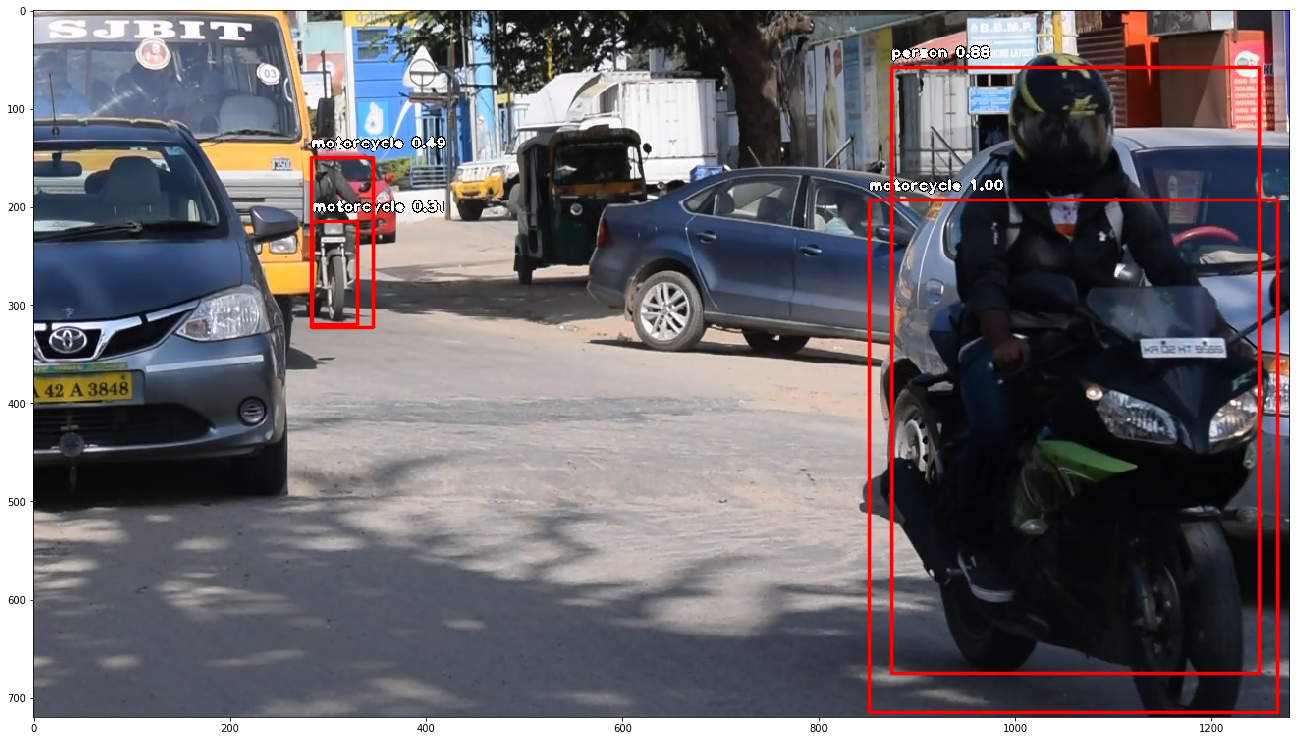

In [19]:
plt.imshow(detected_copy)

In [23]:
sess.close()

In [21]:
detected_copy = cv2.cvtColor(detected_copy, cv2.COLOR_RGB2BGR)
cv2.imwrite("Object_Detected.jpg", detected_copy)
detected_copy = cv2.cvtColor(detected_copy, cv2.COLOR_BGR2RGB)

In [40]:
import keras

In [ ]:
keras.layers.Conv1D()

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [ ]:
=